# Imports and setting up environment

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import sklearn 
import pandas as pd
!pip install contractions
import contractions
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow_hub as hub

tf.random.set_seed(0)

nltk.download('omw-1.4')
nltk.download('wordnet') # we will use wordnet lemmatizer
nltk.download('averaged_perceptron_tagger') #to be used for tagger
nltk.download('punkt') 
nltk.download('stopwords') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

The dataset consists of 97627 rows with 9 columns.

In [3]:
df1 = pd.read_csv("/content/drive/MyDrive/STA 4365: Stats Alg for ML 2/aita_clean_full.csv", encoding_errors = 'ignore', encoding = 'utf-8')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97628 entries, 0 to 97627
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            97628 non-null  object 
 1   timestamp     97628 non-null  float64
 2   title         97628 non-null  object 
 3   body          97541 non-null  object 
 4   edited        97628 non-null  object 
 5   verdict       97628 non-null  object 
 6   score         97628 non-null  int64  
 7   num_comments  97628 non-null  float64
 8   is_asshole    97628 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 6.7+ MB


* id: a unique string provided by Reddit's API to index every post
timestamp of post creation
* title: a string
* body: a string
* edited: whether or not the post has been edited
* verdict: a string in the set {"asshole", "not the asshole", "everyone sucks", "no assholes here")
* score: an integer corresponding to the difference between upvotes and downvotes
* num_comments: an integer corresponding to the total number of comments to the post
* is_asshole: a boolean corresponding to whether the verdict is in the set {"asshole","everyone sucks"}

In [5]:
df1.shape 

(97628, 9)

In [6]:
df1["verdict"].unique()

array(['asshole', 'not the asshole', 'everyone sucks', 'no assholes here'],
      dtype=object)

In [7]:
df1.dropna(inplace = True)
df1.shape

(97541, 9)

### How many posts are in each verdict?

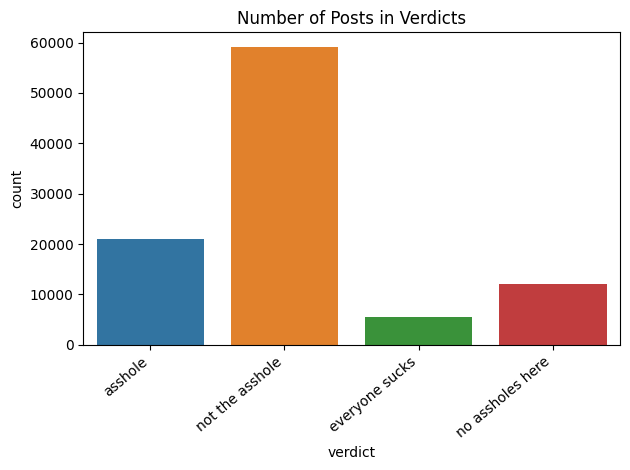

In [8]:
verdict_plot = sns.countplot(x = "verdict", data = df1)
verdict_plot.set_xticklabels(verdict_plot.get_xticklabels(), rotation = 40, ha = "right")
plt.title('Number of Posts in Verdicts')
plt.tight_layout()

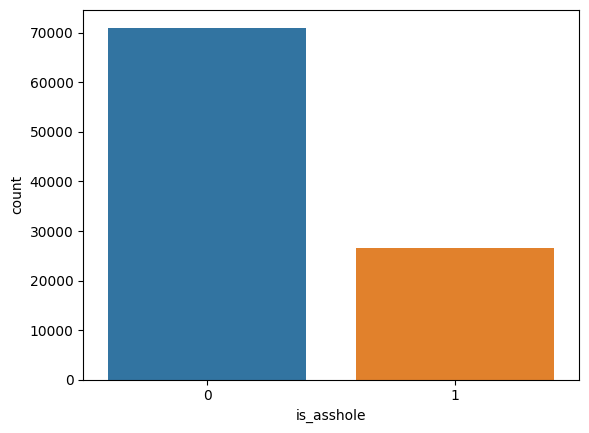

In [9]:
verdict_plot = sns.countplot(x = "is_asshole", data = df1)

In [10]:
df1['edited'] = np.select([df1['edited'] == 'False'], [False], True)
df1.head()

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",True,asshole,140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,True,everyone sucks,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,False,asshole,22,15.0,1


You can see that there are a lot of NTA (not the a\*hole) compared to the others. Which makes sense given the nature of the forum: many people post in hopes for affirmation. In other words, you are more likely to post if you are not the a\*hole.

## Examine the columns compared to the verdict

In [11]:
df1['is_asshole']= df1['is_asshole'].astype(bool)

Text(0.5, 1.0, 'Edits For A*hole')

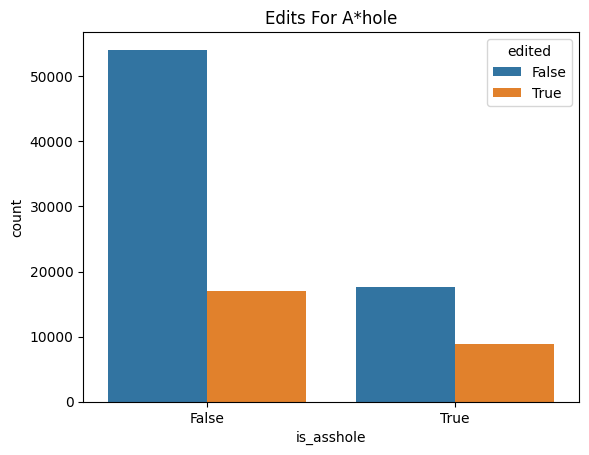

In [12]:
sns.countplot(x = df1['is_asshole'], hue = df1['edited'])
plt.title('Edits For A*hole')

There are many people that do not make edits whether or not the were deemed the a*hole.

In [13]:
df1.describe()

,timestamp,score,num_comments
count,9.754100e+04,97541.000000,97541.000000
mean,1.561363e+09,324.838099,85.332168
std,1.781309e+07,1965.611905,312.535658
min,1.393279e+09,3.000000,1.000000
25%,1.554828e+09,5.000000,14.000000
50%,1.564006e+09,10.000000,23.000000
75%,1.572447e+09,37.000000,46.000000
max,1.580578e+09,59187.000000,11906.000000


Text(0.5, 1.0, 'Scores for is_a*hole')

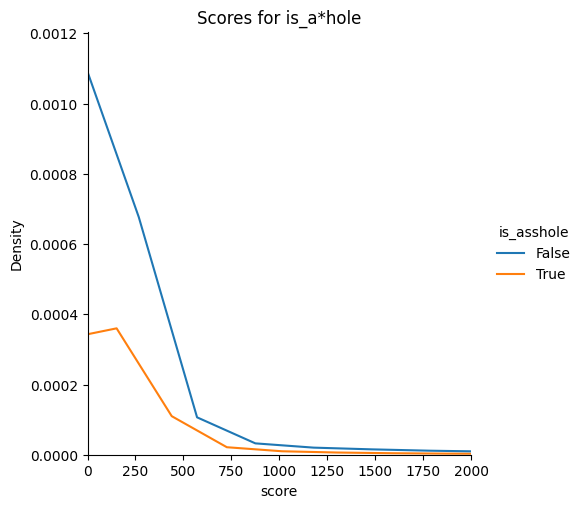

In [14]:
sns.displot(data=df1, x='score', hue='is_asshole', kind = "kde")
plt.xlim(0,2000)
plt.title('Scores for is_a*hole')

This density plot shows that the score for most posts, regardless of verdict, is concentrated between 0 and 500.

Text(0.5, 1.0, 'Number of comments for is_a*hole')

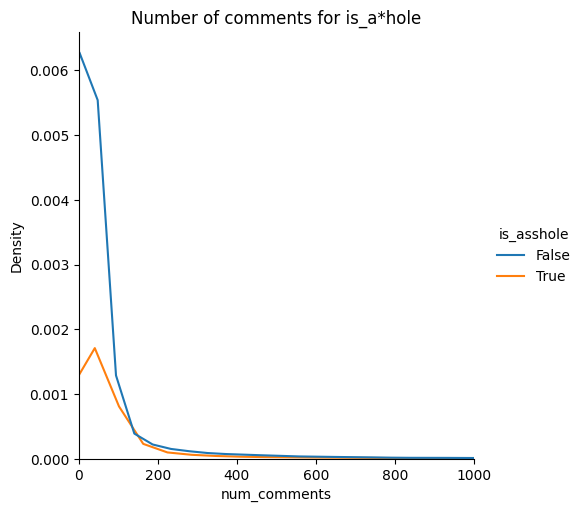

In [15]:
sns.displot(data=df1, x='num_comments', hue='is_asshole', kind = "kde")
plt.xlim(0,1000)
plt.title('Number of comments for is_a*hole')

Regardless of verdict, the density plot indicates that most posts contain number of comments between 0 and 200.

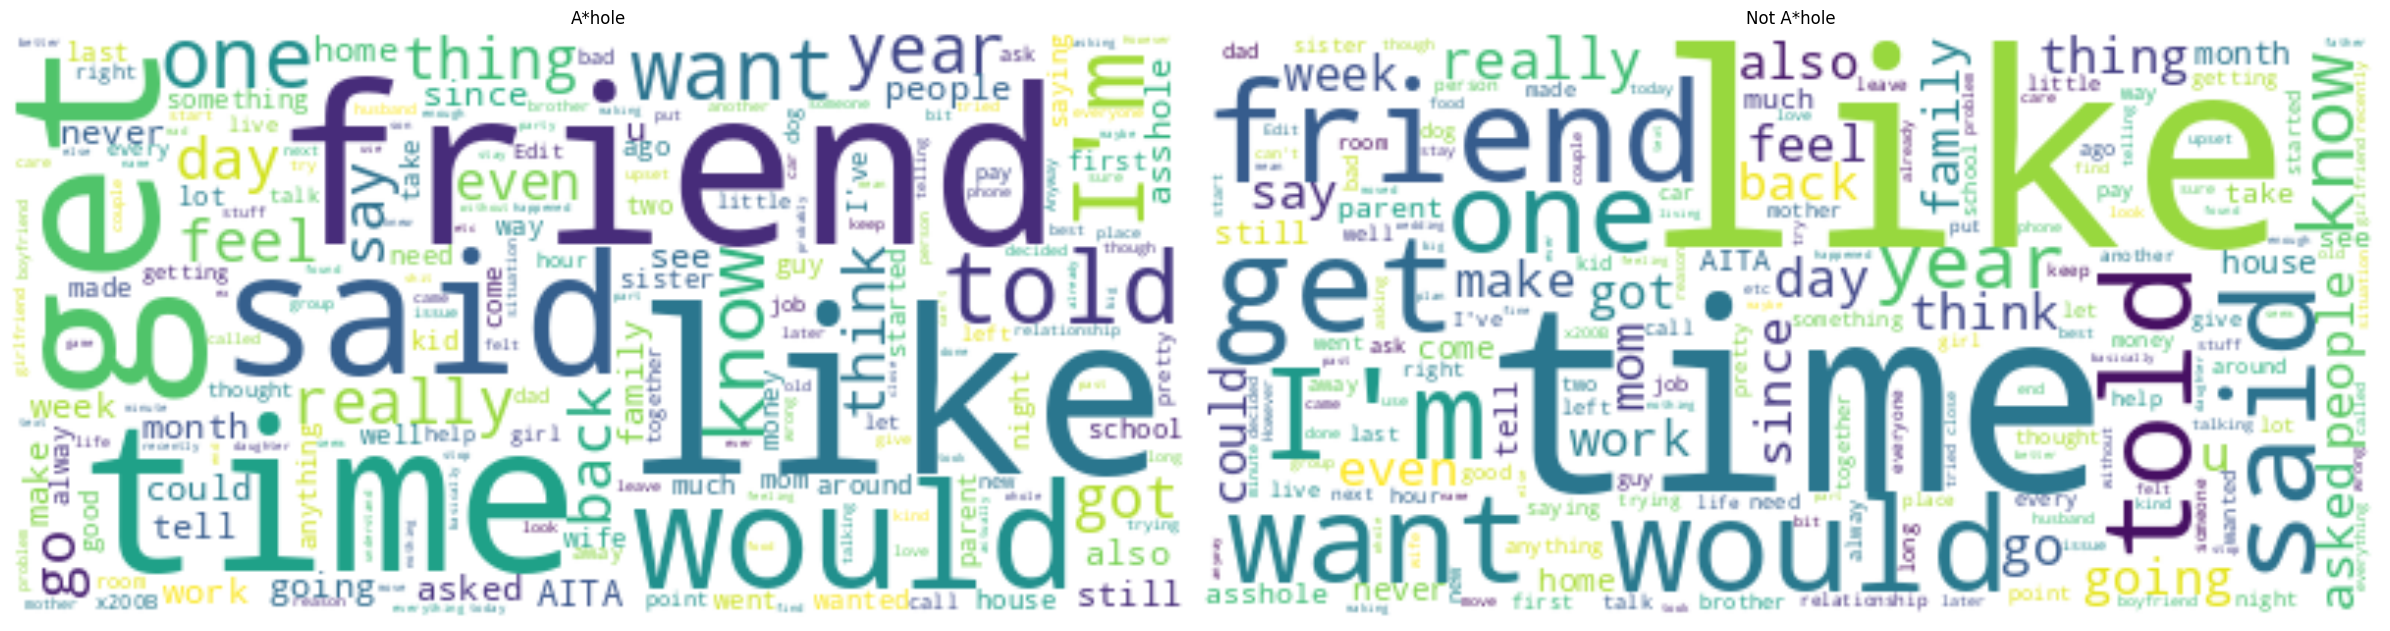

In [16]:
def generate_wordcloud(verdict):
    df_temp = df1[df1['is_asshole'] == verdict]
    text = " ".join(cat for cat in df_temp['body'])
    word_cloud = WordCloud(collocations = False, background_color = 'white', stopwords = nltk.corpus.stopwords.words("english")).generate(text)
    return word_cloud

_, axs = plt.subplots(1, 2,figsize=(24, 12))
for i, ax in enumerate(axs.flatten()):
    verdict = df1['is_asshole'].unique()[i]
    ax.imshow(generate_wordcloud(verdict), interpolation='bilinear')
    if verdict == 1:
        ax.set_title("A*hole")
    else:
        ax.set_title("Not A*hole")
    ax.axis("off")
plt.tight_layout()
plt.show()


In viewing the wordClouds, it is unclear which one is the A\*hole and Not the A*hole based on the which words stand out. This is most likely indicative of the classifier performances to come.

# Models

This function is used to preprocess the text data. We want to make the text lowercase, remove any hyperlinks, expand contractions, remove punctuation, remove stopwords, tokenize and lemmatize the text. As you can see, stop words were commented out because I thought words like "I", "not", "no", etc. might be useful in determining the context of the sentence when using the neural network. Which proved true as accuracy increased with its removal and the standard models did not change much in terms of accuracy.

In [17]:
def text_process(text):
    #Convert to lower case
    text = text.lower()
    
    #remove hyperlinks
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    
    #remove line breaks
    text = text.replace(r'/\s\s+/g', ' ').replace('\n',' ')
    
    #expand contractions
    expanded_words = []
    for word in text.split():
      expanded_words.append(contractions.fix(word)) 
    
    expanded_text = ' '.join(expanded_words)

    #remove punctuation
    text = expanded_text.translate(str.maketrans('','', string.punctuation))
    
    # remove stopwords
    # text = text.split()
    # useless_words = nltk.corpus.stopwords.words("english") + ['aita', 'wibta']
    # text_filtered = [word for word in text if not word in useless_words]
    # text_filtered = ' '.join(text_filtered)
    text_filtered = text
    
    text_filtered = text_filtered.replace(r'\'', ' ')

    # Tokenize each word
    tokenized_text =  nltk.WordPunctTokenizer().tokenize(text_filtered)
    
    # # Lemmatize each token
    lem = WordNetLemmatizer()
    text_stemmed = [lem.lemmatize(y) for y in tokenized_text]
    
    return text_stemmed

Next, we want to clean up the data to make make sure there are no characters not translated to ASCII (this helps with encoding purposes in the neural network) and apply the text processing to the entire dataset.

In [18]:
def remove_non_ascii(text):
    return ''.join(c for c in text if ord(c) < 128)

df1['body'] = df1['body'].apply(lambda x: remove_non_ascii(x))
df1['body'] = df1['body'].apply(lambda x: ' '.join(text_process(x)))

We are only interested in the text of the body and the labels when making our predictions. Although, I have tested the addition of the other variables does increase the accuracy, but in lieu of focusing on pure text classification, they were not added. We split the data in to train, test, and validation sets

In [19]:
X = df1['body']
y = df1['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state= 0)

As mentioned earlier, this dataset is severely imbalanced. Thus, since the dataset is fairly huge, I undersampled the majority dataset.

In [20]:
Counter(y_train)

Counter({False: 45497, True: 16928})

In [21]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))
Counter(y_train)

Counter({False: 16928, True: 16928})

## Logistic Regression

Logistic Regression is the first model because it is often used for simple binary classification. I have a pipeline that uses a TfidfVectorizer(), which is Term Frequency Inverse Document Frequency, and is used to show the importance of a word: if the word shows up in the document more often, but less often in other documents, it is important. Then, I fit the Logistic Regression Classifier.

In [22]:
X_train = X_train.ravel()
y_train = y_train.ravel()

pipeline = Pipeline([
    ('preprocessor', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

model_lr = pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
y_pred_lr = pipeline.predict(X_test)
print(classification_report(y_pred_lr, y_test))

              precision    recall  f1-score   support

       False       0.59      0.79      0.68     10598
        True       0.59      0.35      0.44      8911

    accuracy                           0.59     19509
   macro avg       0.59      0.57      0.56     19509
weighted avg       0.59      0.59      0.57     19509



In [24]:
lr_acc = accuracy_score(y_test, y_pred_lr)

Text(77.92222222222227, 0.5, 'Pred Class')

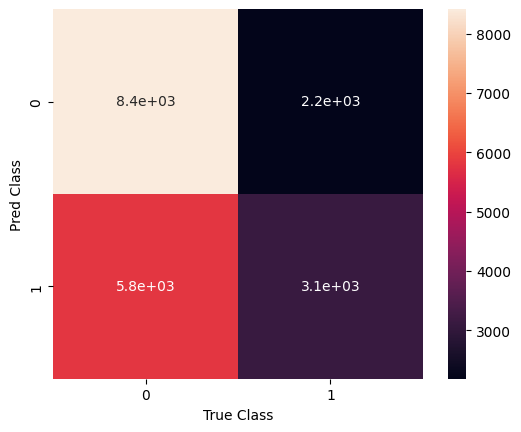

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm.T, square=True, annot=True)
plt.xlabel("True Class")
plt.ylabel("Pred Class")

The confusion matrix indicates that this model outputs a lot of False Positives, labeling Non-A*holes as A\*holes.

## Multinomial NB

The next classifier used is the Multinomial Naive Bayes. NB is often used for text classification tasks because it handles high dimensional sparse data, like text data, well. It useful for tasks that have discrete features like word count. Assuming that the features (words) are conditionally independent of each other, the classifier outputs the probability of each word vector belonging to each class.

In [26]:
pipeline = Pipeline([
    ('preprocessor', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

model_nb = pipeline.fit(X_train, y_train)

In [27]:
y_pred_nb = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

       False       0.77      0.71      0.74     14215
        True       0.36      0.44      0.40      5294

    accuracy                           0.64     19509
   macro avg       0.57      0.57      0.57     19509
weighted avg       0.66      0.64      0.65     19509



In [28]:
nb_acc = accuracy_score(y_test, y_pred_nb)

Text(77.92222222222227, 0.5, 'Pred Class')

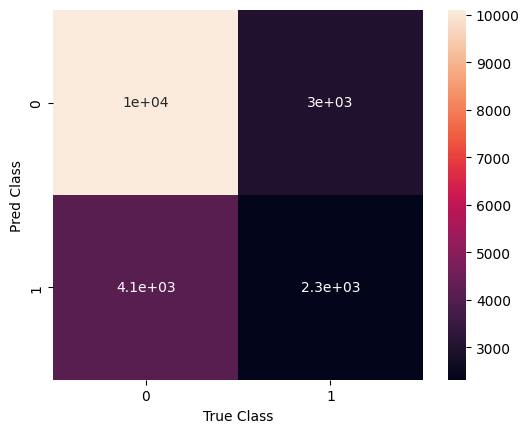

In [29]:
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm.T, square=True, annot=True)
plt.xlabel("True Class")
plt.ylabel("Pred Class")

Again, there is a strong tendency to predict False Positives.

## Random Forest Classifier

The Random Forest Classifier was chosen because I felt that decision trees are pretty robust classifiers, as they tend to not be impacted by noise and outliers and are often used for many different tasks. Interestingly, when I ran my initial model with an imbalanced dataset, the accuracy was high (~0.74), however, after resampling to have even classes, the accuracy decreased.

In [30]:
pipeline = Pipeline([
    ('preprocessor', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

model_rfc = pipeline.fit(X_train, y_train)

In [31]:
y_pred_rfc = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

       False       0.77      0.60      0.68     14215
        True       0.33      0.53      0.41      5294

    accuracy                           0.58     19509
   macro avg       0.55      0.57      0.54     19509
weighted avg       0.65      0.58      0.60     19509



In [32]:
rfc_acc = accuracy_score(y_test, y_pred_rfc)

Text(77.92222222222227, 0.5, 'Pred Class')

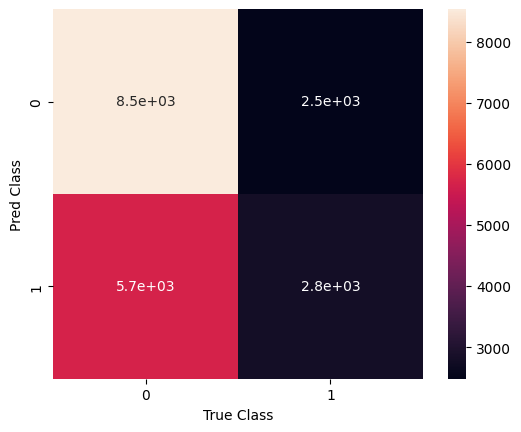

In [33]:
cm = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cm.T, square=True, annot=True)
plt.xlabel("True Class")
plt.ylabel("Pred Class")

This classifier has the same issues as the above classifiers: they all tend to output False Positives.

# Neural Network

## Create our Datasets

Calculate the number of unique words in the text. This is indicative of vocabulary size.

In [34]:
len_text = set()
df1['body'].str.lower().str.split().apply(len_text.update)
vocab_size = len(len_text)
vocab_size

122870

Showing the length of the datasets as well as the class distribution. We want to ensure that the train dataset is balanced while the validation and test sets should be untouched. Then we want to create dataframes for each dataset to facilitate the Dataset object creation for each set.

In [35]:
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Validation data len:'+str(len(X_val)))
print('Class distribution'+ str(Counter(y_val)))
print('Test data len:'+str(len(X_test)))
print('Class distribution'+ str(Counter(y_test)))

X_train = pd.Series(X_train.flatten())
y_train = pd.Series(y_train.flatten())

df_nn_train = pd.concat([X_train, y_train], axis = 1)
df_nn_train = df_nn_train.rename(columns ={0:'text', 1:'label'})
df_nn_test = pd.concat([X_test, y_test], axis = 1)
df_nn_test = df_nn_test.rename(columns ={'body':'text', 'is_asshole':'label'})
df_nn_val = pd.concat([X_val, y_val], axis = 1)
df_nn_val = df_nn_val.rename(columns ={'body':'text', 'is_asshole':'label'})

Train data len:33856
Class distributionCounter({False: 16928, True: 16928})
Validation data len:15607
Class distributionCounter({False: 11358, True: 4249})
Test data len:19509
Class distributionCounter({False: 14215, True: 5294})


Translate pandas dataframes to TensorFlow Dataset so we are able to use tensorflow libraries.

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((df_nn_train['text'].values, df_nn_train['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((df_nn_test['text'].values, df_nn_test['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((df_nn_val['text'].values, df_nn_val['label'].values))

print('Train dataset size:', len(list(train_dataset)))
print('Test dataset size:', len(list(test_dataset)))
print('Val dataset size:', len(list(val_dataset)))

Train dataset size: 33856
Test dataset size: 19509
Val dataset size: 15607


Check the datatype in the tensors to ensure that the translation was made correctly.

In [37]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.bool, name=None))

Output some data to see what we're working with.

In [38]:
for example, label in train_dataset.take(1):
  print('text: ', example)
  print('label: ', label)

text:  tf.Tensor(b'we moved into this house last year not caring that the neighbor had two large german shephards fwiw i do not think we even knew they had dog until after we moved in but it is not like it would have kept u from buying the house they generally free roam their fenced in backyard but the fence is only 4 12 foot tall if that these dog are large dog that i cannot imagine would have any trouble at all hopping that fence if they so desired we noticed pretty quickly though that these dog had a tendency of charging the fence when someone walked by i would have no problem if they just ran up out of curiousity but they charge at it barking wildly barring their teeth and growling a someone who used to be terrified of dog this is incredibly unsettling not to mention the fact that we have a 100 pound lab mix of our own who right now can only use the front yard while leashed out of concern for his safety my mom found the homeowner on facebook and sent her a message about u potential

Split the dataset into batches and use prefetch(tf.data.AUTOTUNE) to optimize performance.

In [39]:
BATCH_SIZE = 50
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Simple Model

Following this tutorial: https://www.freecodecamp.org/news/text-classification-tensorflow/

In [40]:
epochs = 5

Tensorflow is a repository of trained machine learning models. In this case, we are using a pretrained embedding layer, nnlm-en-dim50, their are many different embeddings provided by hub, but this one runs the fastest. An embedding is needed to translate the words to numbers that the network is able to understand. 

In [41]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,dtype = tf.string, trainable = True)

Here we see that the hub_layer translates the text to a vector of length 50 (the embedding is a 50 dimension embedding)

In [42]:
hub_layer(list(train_dataset)[0][0])

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[ 0.78241277, -0.0759911 , -0.16492207, ..., -0.5169453 ,
         0.12169532,  0.06372987],
       [ 0.9138233 , -0.38239032, -0.6221831 , ..., -0.7871923 ,
         0.22360748,  0.45409998],
       [ 1.0302685 , -0.35988685, -0.7250051 , ..., -0.902135  ,
         0.5033601 ,  0.24983709],
       ...,
       [ 0.74560565, -0.22846483, -0.317381  , ..., -0.40103638,
         0.23057944,  0.1922842 ],
       [ 0.8545166 , -0.33019477, -0.2708527 , ..., -0.6342624 ,
        -0.12397889,  0.06306376],
       [ 0.51340306, -0.33143538, -0.18250826, ..., -0.3954292 ,
         0.05129809,  0.3117639 ]], dtype=float32)>

This model is a simple model that contains only Dense and Dropout Layers. I used activation of tanh for the first and hidden layers, but a sigmoid activation because we want to output a probability between 0 and 1. In between the dense layers are Dropout layers, which serve to add some randomness to the model, they cause the network to skip some nodes to prevent overfitting. The numbers for the neurons and dropout percentage are completely arbitrary. In testing many combinations of parameters, these are the ones that yielded the highest accuracy.

In [43]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(24, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

When compiling the model, we want to use the Adam optimizer with a learning rate of 0.001, have the loss function be Binary Cross Entropy, and the metric of evaluation as Accuracy.

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =['accuracy'])

In [45]:
history = model.fit(train_dataset, epochs=epochs, validation_data = val_dataset)

Epoch 1/5
678/678 [==============================] - 92s 130ms/step - loss: 0.7001 - accuracy: 0.5159 - val_loss: 0.6750 - val_accuracy: 0.5956
Epoch 2/5
678/678 [==============================] - 38s 56ms/step - loss: 0.6777 - accuracy: 0.5761 - val_loss: 0.6629 - val_accuracy: 0.6034
Epoch 3/5
678/678 [==============================] - 27s 39ms/step - loss: 0.6446 - accuracy: 0.6327 - val_loss: 0.7260 - val_accuracy: 0.5312
Epoch 4/5
678/678 [==============================] - 22s 33ms/step - loss: 0.5992 - accuracy: 0.6873 - val_loss: 0.7220 - val_accuracy: 0.5719
Epoch 5/5
678/678 [==============================] - 21s 31ms/step - loss: 0.5529 - accuracy: 0.7297 - val_loss: 0.6622 - val_accuracy: 0.6446


In plotting the training and validation accuracy, we see that the Training Accuracy increases as it should, but the validation accuracy should more or less follow the same trend. However, it seems that the validation accuracy decreased then increased again near the end.

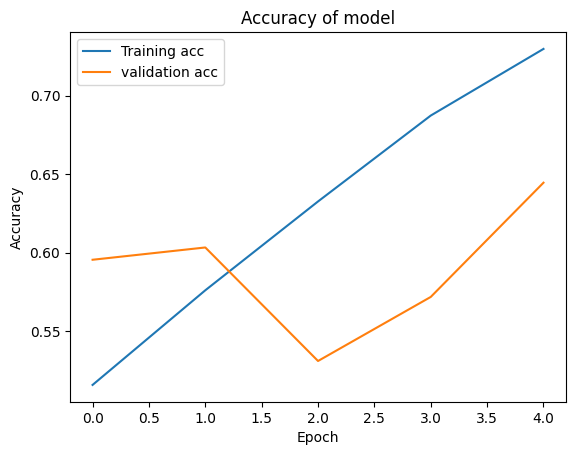

In [46]:
plt.plot(history.history['accuracy'], label = "Training acc")
plt.plot(history.history['val_accuracy'], label = "validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [47]:
test_loss_sim, test_accuracy_sim = model.evaluate(test_dataset)

391/391 [==============================] - 3s 8ms/step - loss: 0.6602 - accuracy: 0.6399


## LSTM Model

Similar to the hub_layer from above, we want to encode the text into numbers. In this case, we use TextVectorization with the max_tokens being the vocab_size (which from earlier is the max amount of unique values in the dataset). We then apply this only to the text data in the train dataset.

In [48]:
encoder = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
encoder.adapt(train_dataset.map(lambda x,y:x))

We then build the vocabulary, which is essentially like a dictionary of indices for the unique words.

In [49]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'and', 'to', 'the', 'a', 'my', 'not', 'it',
       'that', 'she', 'is', 'of', 'wa', 'me', 'her', 'for', 'he', 'in'],
      dtype='<U308')

In [50]:
len(encoder.get_vocabulary())

67156

Then, we build the model. First, we want to pass in the encoder to vectorize our text. Then, we need an embedding for the vectorized text, which just maps semantically similar words to a look up table. Then we ensure that there is a mask because not all the text lengths are the same and neural networks generally work with fixed length inputs, and the output dimension should be equal to the input dimension of the LSTM. This was arbitrarily chosen as are the other dimensions in the following layers because of all the combinations I tried, they yielded the highest accuracy.

In [51]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')

])

We compile the model with the same parameters used previously

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =['accuracy'])

In [53]:
history = model.fit(train_dataset, epochs=epochs, validation_data = val_dataset)

Epoch 1/5
678/678 [==============================] - 170s 242ms/step - loss: 0.6921 - accuracy: 0.5189 - val_loss: 0.6888 - val_accuracy: 0.5167
Epoch 2/5
678/678 [==============================] - 101s 149ms/step - loss: 0.6651 - accuracy: 0.6007 - val_loss: 0.6894 - val_accuracy: 0.5559
Epoch 3/5
678/678 [==============================] - 84s 125ms/step - loss: 0.5956 - accuracy: 0.6845 - val_loss: 0.7381 - val_accuracy: 0.5363
Epoch 4/5
678/678 [==============================] - 83s 123ms/step - loss: 0.4981 - accuracy: 0.7613 - val_loss: 0.8503 - val_accuracy: 0.5295
Epoch 5/5
678/678 [==============================] - 87s 128ms/step - loss: 0.4094 - accuracy: 0.8176 - val_loss: 0.9051 - val_accuracy: 0.5948


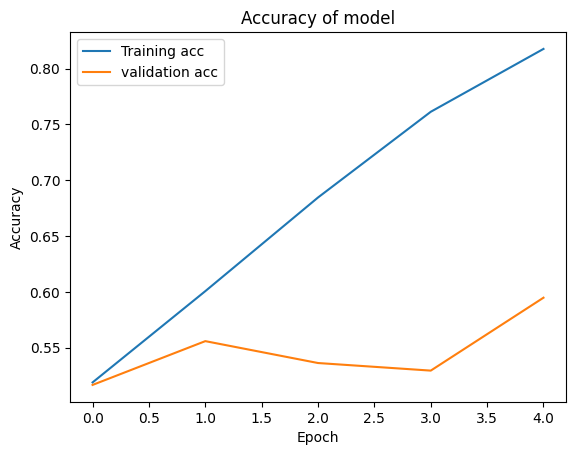

In [54]:
plt.plot(history.history['accuracy'], label = "Training acc")
plt.plot(history.history['val_accuracy'], label = "validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [55]:
test_loss_lstm, test_accuracy_lstm = model.evaluate(test_dataset)

391/391 [==============================] - 7s 19ms/step - loss: 0.8890 - accuracy: 0.5999


# Comparing All Models

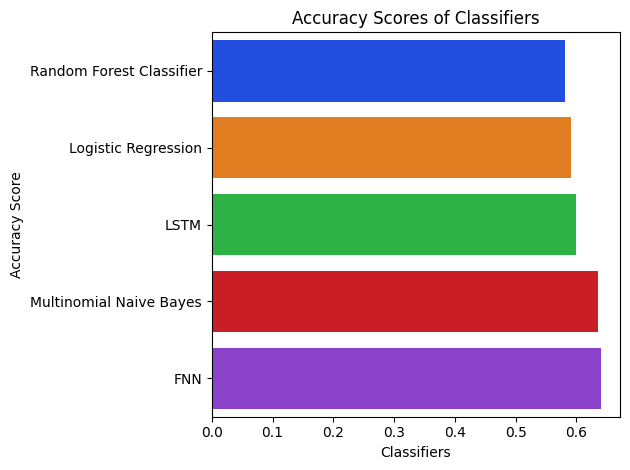

In [56]:
accuracy_scores = [lr_acc, nb_acc, rfc_acc, test_accuracy_lstm, test_accuracy_sim]

classifiers = ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest Classifier', 'LSTM','FNN']

data = sorted(list(zip(accuracy_scores, classifiers)), key = lambda x: x[0])
acc_score, classifier = zip(*data)

classifier_plot = sns.barplot(y=list(classifier), x=list(acc_score), palette='bright')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores of Classifiers')
plt.tight_layout()

We can see that FNN has the highest accuracy score, closely followed by the Multibnomial NB, then LSTM, Logistic Regression, and Random Forest Classifier. I predicted LSTM to have the highest accuracy because it is the most "complex", then FNN would follow since it is a neural network and I expected it to perform better than the other "normal" classifiers. Then the Random Forest Classifier would be the next highest because Decision Trees are usually robust and are one of the better performing nonlinear classifiers, then Multinomial Naive Bayes and Logistic Regression, because it's the simplest. Overall, these accuracies are not good at all, they're just slightly better than random. However, I think this project achieves the goal of comparing performance amongst these various models.